In [1]:
import numpy as np
import xarray as xr
from struct import unpack
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import holoviews as hv
import cupy as cp
from numba import vectorize
hv.extension('matplotlib')

class ReadBinHdr(object):

    ''' Read binary trace header for a trace '''

    def __init__(self, bh):
        if len(bh) != 400:
            print("Binary header should be 400 bytes long")
        else:
            self.jobid = unpack(">i", bh[0:4])[0]
            self.line = unpack(">i", bh[4:8])[0]
            self.reel = unpack(">i", bh[8:12])[0]
            self.numtrcens = unpack(">h", bh[12:14])[0]
            self.numauxtrcs = unpack(">h", bh[14:16])[0]
            self.sampint = unpack(">h", bh[16:18])[0]
            self.sampint2 = unpack(">h", bh[18:20])[0]
            self.samppertrc = unpack(">h", bh[20:22])[0]
            self.samppertrc2 = unpack(">h", bh[22:24])[0]
            self.datasampcode = unpack(">h", bh[24:26])[0]
            self.ensfold = unpack(">h", bh[26:28])[0]
            self.sortcode = unpack(">h", bh[28:30])[0]
            self.dis_units = unpack(">h", bh[54:56])[0]
            self.segyformat = unpack(">h", bh[300:302])[0] // 256
            self.lengthflag = unpack(">h", bh[302:304])[0]
            self.numexthdrs = unpack(">h", bh[304:306])[0]

    def __str__(self):
        return "Job ID : {} \nLine Number : {} \nReel Number : {}\
                 \nNumber of traces per ensemble : {} \nNumber of Aux Traces : {}\
                 \nSample interval : {}\nField Sample Interval : {}\nSample per trace :{}\
                 \nField Samples per Trace : {} \nSample Format : {}\nEnsemble Fold : {}\
                 \nTrace Sorting Code : {}\nMeasurement units(1-Meters 2-Feet) : {}\
                 \nSEGY Format : {}\nLength Flag(0-Variable 1-Fixed) : {}\
                 \nNumber of Extended Text : {}".format(self.jobid, self.line, self.reel, \
                 self.numtrcens, self.numauxtrcs, self.sampint, self.sampint2, self.samppertrc, \
                 self.samppertrc2, self.datasampcode, self.ensfold, self.sortcode, self.dis_units, \
                 self.segyformat, self.lengthflag, self.numexthdrs)
    
class ReadTrcHdr(object):
    ''' Read Trace header '''
    def __init__(self, bh):
        if len(bh) != 240:
            print("Trace Header should be 240 bytes long")
        else:
            self.inline = unpack(">i", bh[220:224])[0]
            self.xline = unpack(">i", bh[20:24])[0]
            self.sou_x = unpack(">i", bh[72:76])[0]
            self.sou_y = unpack(">i", bh[76:80])[0]

    def __str__(self):
        return "##########################START################################\
                \nLine Sequence Number : {}\nReel Sequence Number : {}\
                \nOriginal field record number : {}\nTrace number within the original field record : {}\
                \nEnergy source point number : {}\
                \nYear : {}\
                \nDay : {}\
                \nHour : {}\
                \nMinute : {}\
                \nSecond : {}\
                \n##############################END###########################".format(*list(self.__dict__.values()))

ibm2ieee = cp.RawKernel(r'''
extern "C" __global__
void ibm2ieee(const unsigned int* x1, float* y) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    unsigned int x = x1[tid];
    if (x != 0){
        int sign = ((x1[tid] >> 31) & 0x01) * (-2) + 1;
        int exponent = (x1[tid] >> 24) & 0x7F;
        int tmp = 4 * (exponent - 64);
        double p;
        if (tmp < 0) {
            int po2 = 1 << (abs(tmp));
            p = (double)(1.0/po2);
        }
        else{
            p = 1 << tmp;
        }
        int mantissa = x1[tid] & 0x00ffffff;
        float frac = ((float)mantissa / 0x1000000);
        y[tid] = sign * frac * p;
    }
    else{
        y[tid] = 0.0;
    }    
}
''', 'ibm2ieee')

@vectorize(['float32(uint32)'])
def ibmtoieee(data):
    if data == 0:
        return 0.0
    sign = data >> 31 & 0x01
    exponent = data >> 24 & 0x7f
    mantissa = (data & 0x00ffffff) / float(pow(2, 24))
    return (1 - 2 * sign) * mantissa * pow(16.0, exponent - 64)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [ ]:
!wget http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy

In [3]:
hdrs = []
trcs = []
trcs_raw = []
with open("Kerry3D.segy","rb") as f:
    EBCDIC = f.read(3200)
    BIN = ReadBinHdr(f.read(400))
    samples_per_trace = BIN.samppertrc
    sample_interval = BIN.sampint
    idx=1
    print("Starting loop....")
    while True:
        tmp = f.read(240)
        if not tmp:
            print("End scanning .......")
            break
        hdr = ReadTrcHdr(tmp).__dict__
        trc = f.read(samples_per_trace*4)
#         xline, inline = hdr["cdp"], hdr["line"]
#         x1 = cp.array(np.frombuffer(trc,dtype='>u4'),dtype=cp.uint32)
#         arr = cp.zeros(x1.size, dtype=cp.float32)
#         ibm2ieee((x1.size,), (1,), (x1, arr))
        arr = ibmtoieee(np.frombuffer(trc,dtype='>u4'))
        hdrs.append(hdr)
        trcs.append(arr)
        trcs_raw.append(trc)
        idx+=1
        if idx % 5000 == 0:
            print(idx,len(trc))
df = pd.DataFrame(hdrs)
df.head()

Starting loop....
5000 5008
10000 5008
15000 5008
20000 5008
25000 5008
30000 5008
35000 5008
40000 5008
45000 5008
50000 5008
55000 5008
60000 5008
65000 5008
70000 5008
75000 5008
80000 5008
85000 5008
90000 5008
95000 5008
100000 5008
105000 5008
110000 5008
115000 5008
120000 5008
125000 5008
130000 5008
135000 5008
140000 5008
145000 5008
150000 5008
155000 5008
160000 5008
165000 5008
170000 5008
175000 5008
180000 5008
185000 5008
190000 5008
195000 5008
200000 5008
205000 5008
210000 5008
End scanning .......


inline  xline    sou_x    sou_y
0     510     58  1703638  5571677
1     510     59  1703638  5571727
2     510     60  1703639  5571777
3     510     61  1703640  5571827
4     510     62  1703641  5571877

In [7]:
ds = Dataset("../data/Kerry.nc","w","NETCDF4")
ds.bin = str(BIN.__dict__)
ds.ebcdic = EBCDIC.decode('cp037').strip("@")

inline = ds.createDimension('inline',len(df.inline.unique()))
xline = ds.createDimension('xline', len(df.xline.unique()))
samples = ds.createDimension('samples',samples_per_trace)

dims = tuple(ds.dimensions.keys())

samples = ds.createVariable("samples", "i4" , "samples")
samples.units = "ms"
samples.long_name = "Sample number"
data = ds.createVariable("data", "f4", dims)
data.units = "Amplitude"
data.long_name = "Sample Amplitude"
data.description = "Kerry 3d Stack New Zealand"
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    bin: {'jobid': 0, 'line': 510, 'reel': 0, 'numtrcens': 1, 'numauxtrcs': 0, 'sampint': 4000, 'sampint2': 0, 'samppertrc': 1252, 'samppertrc2': 0, 'datasampcode': 1, 'ensfold': 1, 'sortcode': 4, 'dis_units': 0, 'segyformat': 0, 'lengthflag': 0, 'numexthdrs': 0}
    ebcdic: C01 AREA        : OFFSHORE TARANAKI - OFFSHORE TARANAKI SEISMIC DATABASE        C02 DESCRIPTION : KERRY3D SEISMIC COVERAGE - PHASE MATCHED IN GEOFRAME          C03 =========================================================================== C04 DATE     :1996       CLASS      :RAW MIGRATION /+90 DEGREE PHASE SHIFT      C05 OPERATOR :WMC        PROCESSING :DIGICON SINGAPORE                          C06 =========================================================================== C07 THE 3D DATA HAS BEEN DATUM AND PHASE SHIFTED. DATA HAS BEEN MERGED WITH     C08 CHECKED NAV AND EXPORTED FROM GEOFRAME 4.2 IN STANDARD SEGY.              

In [8]:
ds["data"][:] = np.array(trcs).reshape(ds["data"].shape)
ds["samples"][:] = np.arange(0, samples_per_trace, dtype=np.timedelta64(1,"ms"))
for hdr in hdrs[0]:
    if hdr in dims:
        ds.createVariable(hdr, "i4", hdr)
        ds[hdr][:] = df[hdr].unique() 
    else:
        ds.createVariable(hdr, "i4", dims[:-1])
        ds[hdr][:] = df[hdr].values.reshape(ds[hdr].shape)

In [9]:
ds['inline'].units = 'Inline'
ds['xline'].units = 'Crossline'
ds.close()

In [10]:
%time kerry = xr.open_dataset("../data/Kerry.nc",chunks={'inline':1,'xline':5,'samples':500})
kerry

CPU times: user 585 ms, sys: 88.3 ms, total: 673 ms
Wall time: 714 ms


<xarray.Dataset>
Dimensions:  (inline: 287, samples: 1252, xline: 735)
Coordinates:
  * samples  (samples) int32 0 1 2 3 4 5 6 ... 1246 1247 1248 1249 1250 1251
  * inline   (inline) int32 510 511 512 513 514 515 ... 791 792 793 794 795 796
  * xline    (xline) int32 58 59 60 61 62 63 64 ... 786 787 788 789 790 791 792
Data variables:
    data     (inline, xline, samples) float32 dask.array<chunksize=(1, 5, 500), meta=np.ndarray>
    sou_x    (inline, xline) int32 dask.array<chunksize=(1, 5), meta=np.ndarray>
    sou_y    (inline, xline) int32 dask.array<chunksize=(1, 5), meta=np.ndarray>
Attributes:
    bin:      {'jobid': 0, 'line': 510, 'reel': 0, 'numtrcens': 1, 'numauxtrc...
    ebcdic:   C01 AREA        : OFFSHORE TARANAKI - OFFSHORE TARANAKI SEISMIC...

CPU times: user 510 ms, sys: 97.4 ms, total: 607 ms
Wall time: 464 ms


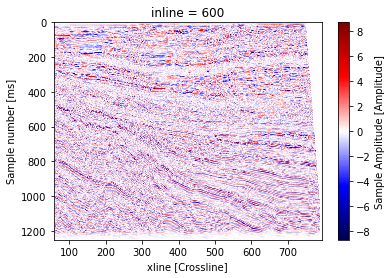

In [21]:
#plot with xarray native matplotlib
%time kerry.data.sel(inline=600,samples=slice(2000)).T.plot(cmap='seismic',robust=False,yincrease=False)

In [17]:
kerry.data.sel(inline=600,samples=slice(500)).T

<xarray.DataArray 'data' (samples: 501, xline: 735)>
dask.array<transpose, shape=(501, 735), dtype=float32, chunksize=(500, 5), chunktype=numpy.ndarray>
Coordinates:
  * samples  (samples) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499 500
    inline   int32 600
  * xline    (xline) int32 58 59 60 61 62 63 64 ... 786 787 788 789 790 791 792
Attributes:
    units:        Amplitude
    long_name:    Sample Amplitude
    description:  Kerry 3d Stack New Zealand

CPU times: user 9.68 ms, sys: 0 ns, total: 9.68 ms
Wall time: 9.56 ms


:Layout
   .QuadMesh.I  :QuadMesh   [xline,samples]   (data)
   .QuadMesh.II :QuadMesh   [inline,samples]   (data)
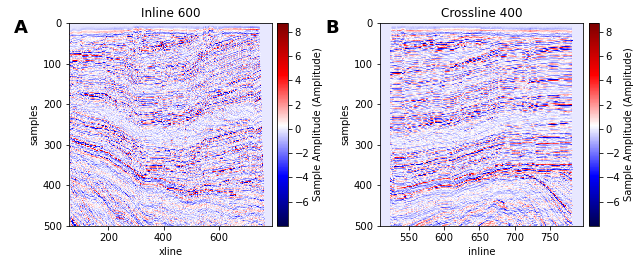

In [29]:
%%time
#plot using holoview quadmesh
il600 = hv.QuadMesh(kerry.data.sel(inline=600,samples=slice(500)).T, ["xline","samples"]).opts(invert_yaxis=True,title="Inline 600",cmap="Seismic",colorbar=True,fig_size=200)
xl400 = hv.QuadMesh(kerry.data.sel(xline=400,samples=slice(500)).T, ["inline","samples"]).opts(invert_yaxis=True,title="Crossline 400",cmap="Seismic",colorbar=True,fig_size=200)
(il600 + xl400)

CPU times: user 4.9 ms, sys: 0 ns, total: 4.9 ms
Wall time: 4.86 ms


:QuadMesh   [xline,samples]   (data)
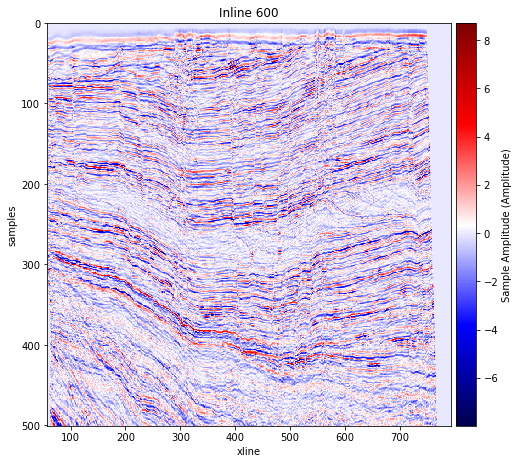

In [31]:
%%time
#plot using holoview quadmesh
il600 = hv.QuadMesh(kerry.data.sel(inline=600,samples=slice(500)).T, ["xline","samples"]).opts(invert_yaxis=True,title="Inline 600",cmap="Seismic",colorbar=True,fig_size=200)
il600

CPU times: user 5 ms, sys: 145 µs, total: 5.14 ms
Wall time: 5.1 ms


:QuadMesh   [inline,samples]   (data)
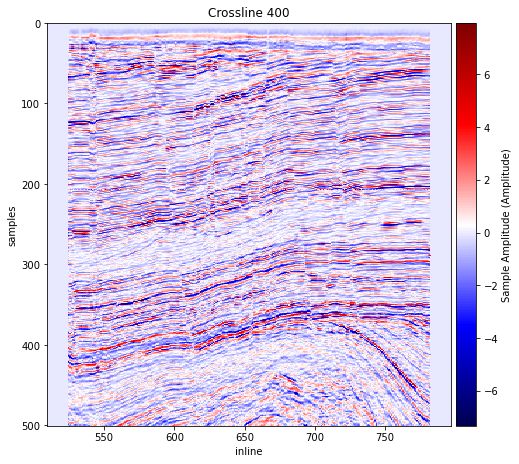

In [32]:
%%time
#plot using holoview quadmesh
xl400 = hv.QuadMesh(kerry.data.sel(xline=400,samples=slice(500)).T, ["inline","samples"]).opts(invert_yaxis=True,title="Crossline 400",cmap="Seismic",colorbar=True,fig_size=200)
xl400

CPU times: user 25.8 ms, sys: 3.89 ms, total: 29.7 ms
Wall time: 29.3 ms


:QuadMesh   [inline,xline]   (data)
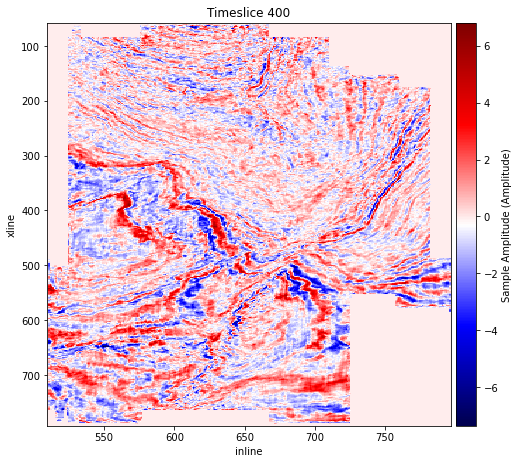

In [33]:
%%time
#plot using holoview quadmesh
ts400 = hv.QuadMesh(kerry.data.sel(samples=400).T, ["inline","xline"]).opts(invert_yaxis=True,title="Timeslice 400",cmap="Seismic",colorbar=True,fig_size=200)
ts400